In [2]:
import os 
import cv2
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import skimage.io as io

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchsummary import summary

from Model.UNetAttentionResNet import UNetAttentionResNet
from Model.UNetAttentionDenseNet import UNetAttentionDenseNet
from Model.UNetAttentionEfficientV2 import UNetAttentionEfficientV2
from Model.UNetEfficientNetV2 import UNetEfficientV2

from diodetools.DiodeLoader import DiodeDataLoader
from diodetools.TrainTest import test, load_state

## Load model

In [3]:
device = torch.device("cpu")

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    return model

res18   = load_model(
    UNetAttentionResNet(device, 'resnet18'), 
    r'./SavedModel/resnet/resnet18_50_epoch_26-04-23.pt')
res34   = load_model(
    UNetAttentionResNet(device, 'resnet34'), 
    r'./SavedModel/resnet/resnet34_50_epoch_26-04-23.pt')
res50   = load_model(
    UNetAttentionResNet(device, 'resnet50'), 
    r'./SavedModel/resnet/resnet50_50_epoch_27-04-23.pt')
res101  = load_model(
    UNetAttentionResNet(device, 'resnet101'), 
    r'./SavedModel/resnet/resnet101_50_epoch_27-04-23.pt')
res152  = load_model(
    UNetAttentionResNet(device, 'resnet152'), 
    r'./SavedModel/resnet/resnet152_50_epoch_27-04-23.pt')

den121  = load_model(
    UNetAttentionDenseNet(device, 'densenet121'), 
    r'./SavedModel/densenet/densenet121_50_epoch_26-04-23.pt')
den169  = load_model(
    UNetAttentionDenseNet(device, 'densenet169'), 
    r'./SavedModel/densenet/densenet169_50_epoch_26-04-23.pt')
den169_a  = load_model(
    UNetAttentionDenseNet(device, 'densenet169', act=True), 
    r'./SavedModel/densenet/densenet169_act_50_epoch_25-04-23.pt')
den201  = load_model(
    UNetAttentionDenseNet(device, 'densenet201'), 
    r'./SavedModel/densenet/densenet201_50_epoch_26-04-23.pt')

ef_s = load_model(
    UNetAttentionEfficientV2(device, 'efficient_v2_s'), 
    r'./SavedModel/efficientnet/efficient_v2_s_50_epoch_28-04-23.pt')
ef_m = load_model(
    UNetAttentionEfficientV2(device, 'efficient_v2_m'), 
    r'./SavedModel/efficientnet/efficient_v2_m_50_epoch_28-04-23.pt')
ef_l = load_model(
    UNetAttentionEfficientV2(device, 'efficient_v2_l'), 
    r'./SavedModel/efficientnet/efficient_v2_l_50_epoch_28-04-23.pt')

u_v2_s = load_model(
    UNetEfficientV2(device, 'efficient_v2_s'), 
    r'./SavedModel/noag_efficientnet/NoAG_UNet_efficient_v2_s_50_epoch_28-04-23.pt')
u_v2_m = load_model(
    UNetEfficientV2(device, 'efficient_v2_m'), 
    r'./SavedModel/noag_efficientnet/NoAG_UNet_efficient_v2_m_50_epoch_28-04-23.pt')
u_v2_l = load_model(
    UNetEfficientV2(device, 'efficient_v2_l'), 
    r'./SavedModel/noag_efficientnet/NoAG_UNet_efficient_v2_l_50_epoch_28-04-23.pt')

c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_We

## Data Preparation

In [2]:
torch.random.manual_seed(1)

TRAIN_PATH = R'../dataset/diode_indoor/train/'
TEST_PATH = r'../dataset/diode_indoor/test/'

def getData(path):
    filelist = []

    for root, dirs, files in os.walk(path):
        for file in files:
            filelist.append(os.path.join(root, file))

    filelist.sort()
    data = {
        "image": [x for x in filelist if x.endswith(".png")],
        "depth": [x for x in filelist if x.endswith("_depth.npy")],
        "mask": [x for x in filelist if x.endswith("_depth_mask.npy")],
    }
    
    df = pd.DataFrame(data)
    return df

df_train = getData(TRAIN_PATH)
df_test = getData(TEST_PATH)

print(f"Train : {df_train.shape}")
print(f"Test  : {df_test.shape}")
print(f"Total Indoor data : {df_train.shape[0] + df_test.shape[0]}")

Train : (8574, 3)
Test  : (325, 3)
Total Indoor data : 8899


## Quantitative Comparison

### ResNet Variant

In [4]:
torch.random.manual_seed(1)
np.random.seed(1)

max_depth = 50
models = [res18, res34, res50, res101, res152]
models_name = ['res-18', 'res-34', 'res-50', 'res-101', 'res-152']

def testing_all_model(loader, models, models_name, max_depth):
    for model, model_name in zip(models, models_name):
        print(model_name)
        test(model=model, l1_weight=0.1, loader=loader, max_depth=max_depth, device='cuda')
        print()
        
        del model

testloader = DataLoader(
                    DiodeDataLoader(df_test, max_depth=max_depth, img_dim=(192, 256), depth_dim=(192, 256)), 
                    batch_size=16, 
                    shuffle=False
                )

testing_all_model(testloader, models, models_name, max_depth)
torch.cuda.empty_cache()

res-18
Testing Phase [Total batch : 21]
Loss : 0.3386 RMSE : 2.0664 REL : 0.4310 ACC^1 : 0.4502 ACC^2 : 0.6791 ACC^3 : 0.7961

res-34
Testing Phase [Total batch : 21]
Loss : 0.3242 RMSE : 2.0288 REL : 0.4224 ACC^1 : 0.4528 ACC^2 : 0.6834 ACC^3 : 0.8038

res-50
Testing Phase [Total batch : 21]
Loss : 0.3111 RMSE : 1.9454 REL : 0.4016 ACC^1 : 0.4911 ACC^2 : 0.7097 ACC^3 : 0.8196

res-101
Testing Phase [Total batch : 21]
Loss : 0.3169 RMSE : 1.9573 REL : 0.3756 ACC^1 : 0.4891 ACC^2 : 0.7128 ACC^3 : 0.8223

res-152
Testing Phase [Total batch : 21]
Loss : 0.3183 RMSE : 1.9479 REL : 0.4029 ACC^1 : 0.4842 ACC^2 : 0.6891 ACC^3 : 0.8032



### DenseNet Variant

In [5]:
torch.random.manual_seed(1)
np.random.seed(1)

max_depth = 50
models = [den121, den169, den201]
models_name = ['den-121', 'den-169', 'den-201']

def testing_all_model(loader, models, models_name, max_depth):
    for model, model_name in zip(models, models_name):
        print(model_name)
        test(model=model, l1_weight=0.1, loader=loader, max_depth=max_depth, device='cuda')
        print()
        
        del model

testloader = DataLoader(
                    DiodeDataLoader(df_test, max_depth=max_depth, img_dim=(192, 256), depth_dim=(192, 256)), 
                    batch_size=16, 
                    shuffle=False
                )

testing_all_model(testloader, models, models_name, max_depth)
torch.cuda.empty_cache()

den-121
Testing Phase [Total batch : 21]
Loss : 0.3200 RMSE : 1.9168 REL : 0.4058 ACC^1 : 0.4823 ACC^2 : 0.7005 ACC^3 : 0.8166

den-169
Testing Phase [Total batch : 21]
Loss : 0.3067 RMSE : 1.9339 REL : 0.4067 ACC^1 : 0.4732 ACC^2 : 0.6946 ACC^3 : 0.8196

den-201
Testing Phase [Total batch : 21]
Loss : 0.3423 RMSE : 1.9234 REL : 0.3833 ACC^1 : 0.4947 ACC^2 : 0.7130 ACC^3 : 0.8220



### DenseNet with act

In [5]:
torch.random.manual_seed(1)
np.random.seed(1)

max_depth = 50
testloader = DataLoader(
                    DiodeDataLoader(df_test, max_depth=max_depth, img_dim=(192, 256), depth_dim=(192, 256)), 
                    batch_size=16, 
                    shuffle=True
                )

print(f'den169_a')
test(model=den169_a, l1_weight=0.1, loader=testloader, max_depth=max_depth, device='cuda')
torch.cuda.empty_cache()

den169_a
Testing Phase [Total batch : 21]
Loss : 0.3087 RMSE : 2.6903 REL : 0.4014 ACC^1 : 0.4693 ACC^2 : 0.6964 ACC^3 : 0.8312


### EfficientNet V2 Variant

In [6]:
torch.random.manual_seed(1)
np.random.seed(1)

max_depth = 50
models = [ef_s, ef_m, ef_l]
models_name = ['ef-V2-s', 'ef-V2-m', 'ef-V2-l']

def testing_all_model(loader, models, models_name, max_depth):
    for model, model_name in zip(models, models_name):
        print(model_name)
        test(model=model, l1_weight=0.1, loader=loader, max_depth=max_depth, device='cuda')
        print()
        
        del model

testloader = DataLoader(
                    DiodeDataLoader(df_test, max_depth=max_depth, img_dim=(192, 256), depth_dim=(192, 256)), 
                    batch_size=32, 
                    shuffle=False
                )

testing_all_model(testloader, models, models_name, max_depth)
torch.cuda.empty_cache()

ef-V2-s
Testing Phase [Total batch : 11]
Loss : 0.3016 RMSE : 1.7716 REL : 0.3720 ACC^1 : 0.5305 ACC^2 : 0.7407 ACC^3 : 0.8567

ef-V2-m
Testing Phase [Total batch : 11]
Loss : 0.3154 RMSE : 1.8449 REL : 0.3827 ACC^1 : 0.5171 ACC^2 : 0.7285 ACC^3 : 0.8475

ef-V2-l
Testing Phase [Total batch : 11]
Loss : 0.2988 RMSE : 1.8169 REL : 0.3701 ACC^1 : 0.5176 ACC^2 : 0.7424 ACC^3 : 0.8427



### No AG - EfficientNet V2 Variant

In [17]:
torch.random.manual_seed(1)
np.random.seed(1)

max_depth = 50
models = [u_v2_s, u_v2_m, u_v2_l]
models_name = ['UE-S', 'UE-M', 'UE-L']

def testing_all_model(loader, models, models_name, max_depth):
    for model, model_name in zip(models, models_name):
        print(model_name)
        test(model=model, l1_weight=0.1, loader=loader, max_depth=max_depth, device='cuda')
        print()
        
        del model

testloader = DataLoader(
                    DiodeDataLoader(df_test, max_depth=max_depth, img_dim=(192, 256), depth_dim=(192, 256)), 
                    batch_size=32, 
                    shuffle=False
                )

testing_all_model(testloader, models, models_name, max_depth)
torch.cuda.empty_cache()

UE-S
Testing Phase [Total batch : 11]
Loss : 0.3003 RMSE : 1.8175 REL : 0.3553 ACC^1 : 0.5140 ACC^2 : 0.7603 ACC^3 : 0.8574

UE-M
Testing Phase [Total batch : 11]
Loss : 0.3066 RMSE : 1.8819 REL : 0.3643 ACC^1 : 0.5128 ACC^2 : 0.7359 ACC^3 : 0.8393

UE-L
Testing Phase [Total batch : 11]
Loss : 0.3053 RMSE : 1.8577 REL : 0.3536 ACC^1 : 0.5385 ACC^2 : 0.7458 ACC^3 : 0.8449



## Visualization

In [3]:
max_depth = 50
loader = DataLoader(
            DiodeDataLoader(df_test, max_depth=max_depth, img_dim=(192, 256), depth_dim=(192, 256)), 
            batch_size=128, 
            shuffle=False
        )
data, depth = next(iter(loader))
print(f"Data : {data.shape}")
print(f"Depth: {depth.shape}")

Data : torch.Size([128, 3, 192, 256])
Depth: torch.Size([128, 1, 192, 256])


In [5]:
# visualize 
def visualize(show_idx, models, models_name, cmap='inferno'):
    with torch.no_grad():
        fig, ax = plt.subplots(nrows=1, ncols=2 + len(models), figsize=(24, 22))
        ax[0].set_title('Image', fontsize=15)
        ax[1].set_title('DepthMap (GT)', fontsize=15)
        
        ax[0].imshow(data[show_idx].permute(1, 2, 0))
        ax[1].imshow(depth[show_idx].squeeze(), cmap=cmap)
        
        start_show_idx = 2
        for model, model_name in (zip(models, models_name)):
            model.eval()
            ax[start_show_idx].set_title(model_name, fontsize=14)
            pred = model(data[show_idx][np.newaxis].to(device)).squeeze().cpu()
            ax[start_show_idx].imshow(pred, cmap=cmap)
        
            start_show_idx += 1
        
        plt.show()

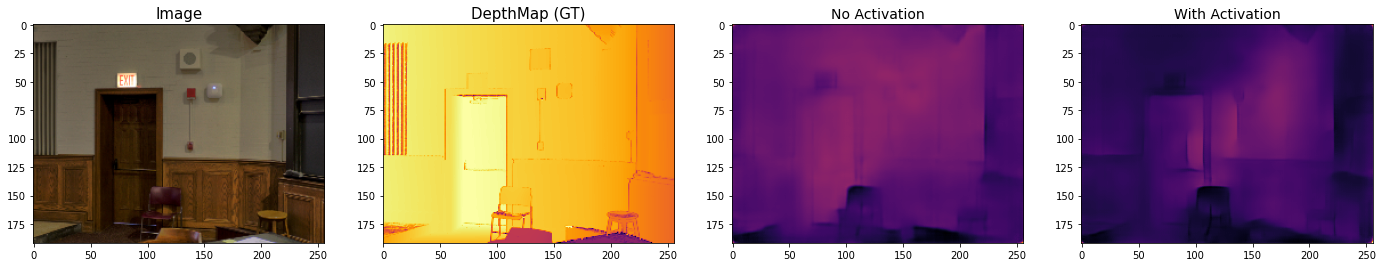

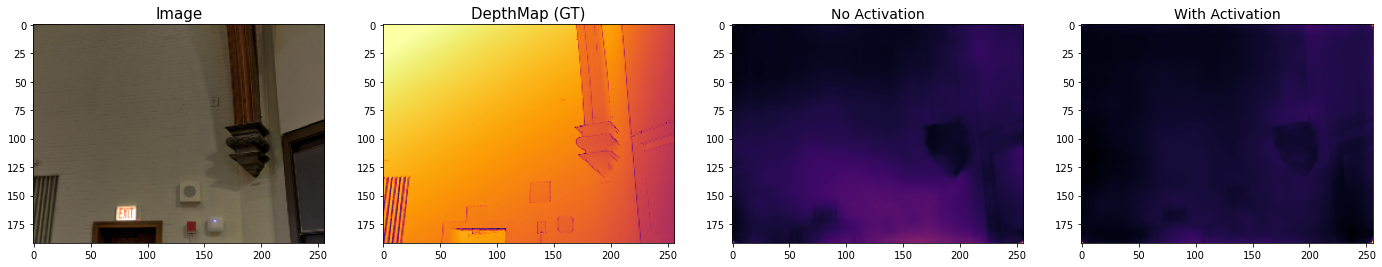

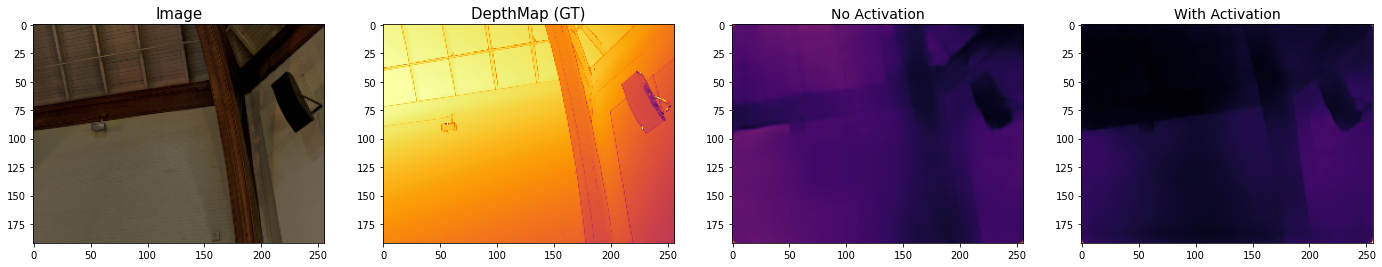

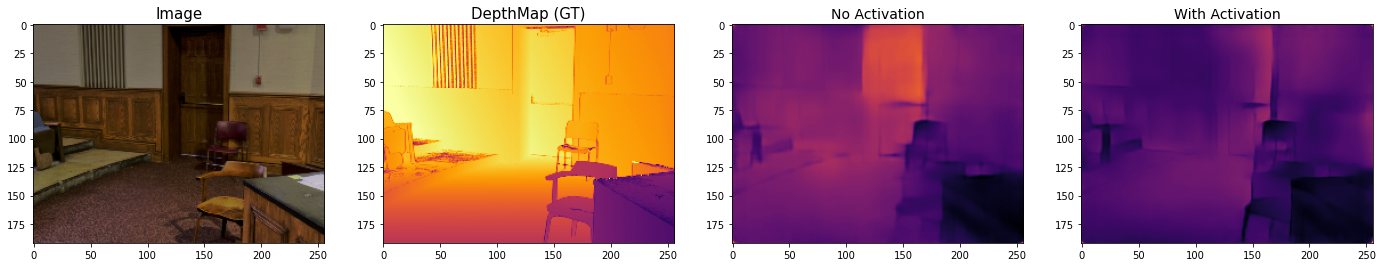

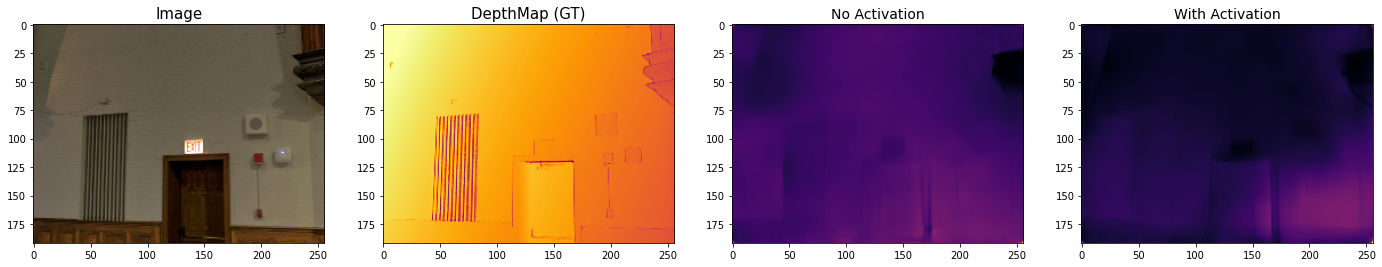

In [8]:
start_show = 20
for idx in range(start_show, start_show + 5):
    visualize(idx, [den169, den169_a], ['No Activation', 'With Activation'], cmap='inferno')

## Custom image

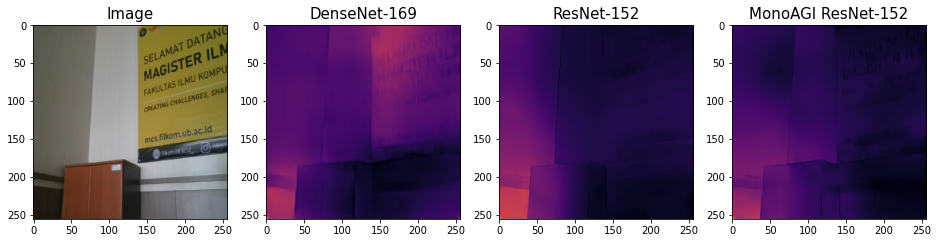

In [11]:
# visualize 
def custom_visualize(img_path, models, models_name, device, cmap='inferno'):
    with torch.no_grad():
        trans = transforms.Compose([
                        transforms.ToTensor(), 
                        transforms.Resize((256, 256))
                    ])
        img = io.imread(img_path)
        img = trans(img[:, :, :3]).to(device)
        
        start_show_idx = 1
        fig, ax = plt.subplots(nrows=1, ncols=start_show_idx+len(models), figsize=(16, 22))
        ax[0].set_title('Image', fontsize=15)
        ax[0].imshow(img.permute(1, 2, 0).cpu())
        
        for model, model_name in (zip(models, models_name)):
            model.eval()
            ax[start_show_idx].set_title(model_name, fontsize=15)
            pred = model(img[None, :, :, :]).squeeze().cpu()
            ax[start_show_idx].imshow(pred, cmap=cmap)
        
            start_show_idx += 1
        
        plt.show()

custom_visualize(
    img_path='./TestSample/uji (1).png', 
    models=models, 
    models_name=models_name, 
    device=device,
    cmap='inferno'
)

## Training Visualization

In [5]:
import re 

model_name = ['DenseNet-121', 'DenseNet-169', 'DenseNet-169 [Act]', 'DenseNet-201', 
                'ResNet-101', 'ResNet-152', 'ResNet-18', 'ResNet-34', 'ResNet-50']
df_readed = [] 

for path in os.listdir('./TrainingHistory/'): 
    print(path)
    df_readed.append(pd.read_csv('./TrainingHistory/' + path))

train_densenet121_50_epoch_26-04-23.csv
train_densenet169_50_epoch_26-04-23.csv
train_densenet169_act_50_epoch_25-04-23.csv
train_densenet201_50_epoch_26-04-23.csv
train_resnet101_50_epoch_27-04-23.csv
train_resnet152_50_epoch_27-04-23.csv
train_resnet18_50_epoch_26-04-23.csv
train_resnet34_50_epoch_26-04-23.csv
train_resnet50_50_epoch_27-04-23.csv


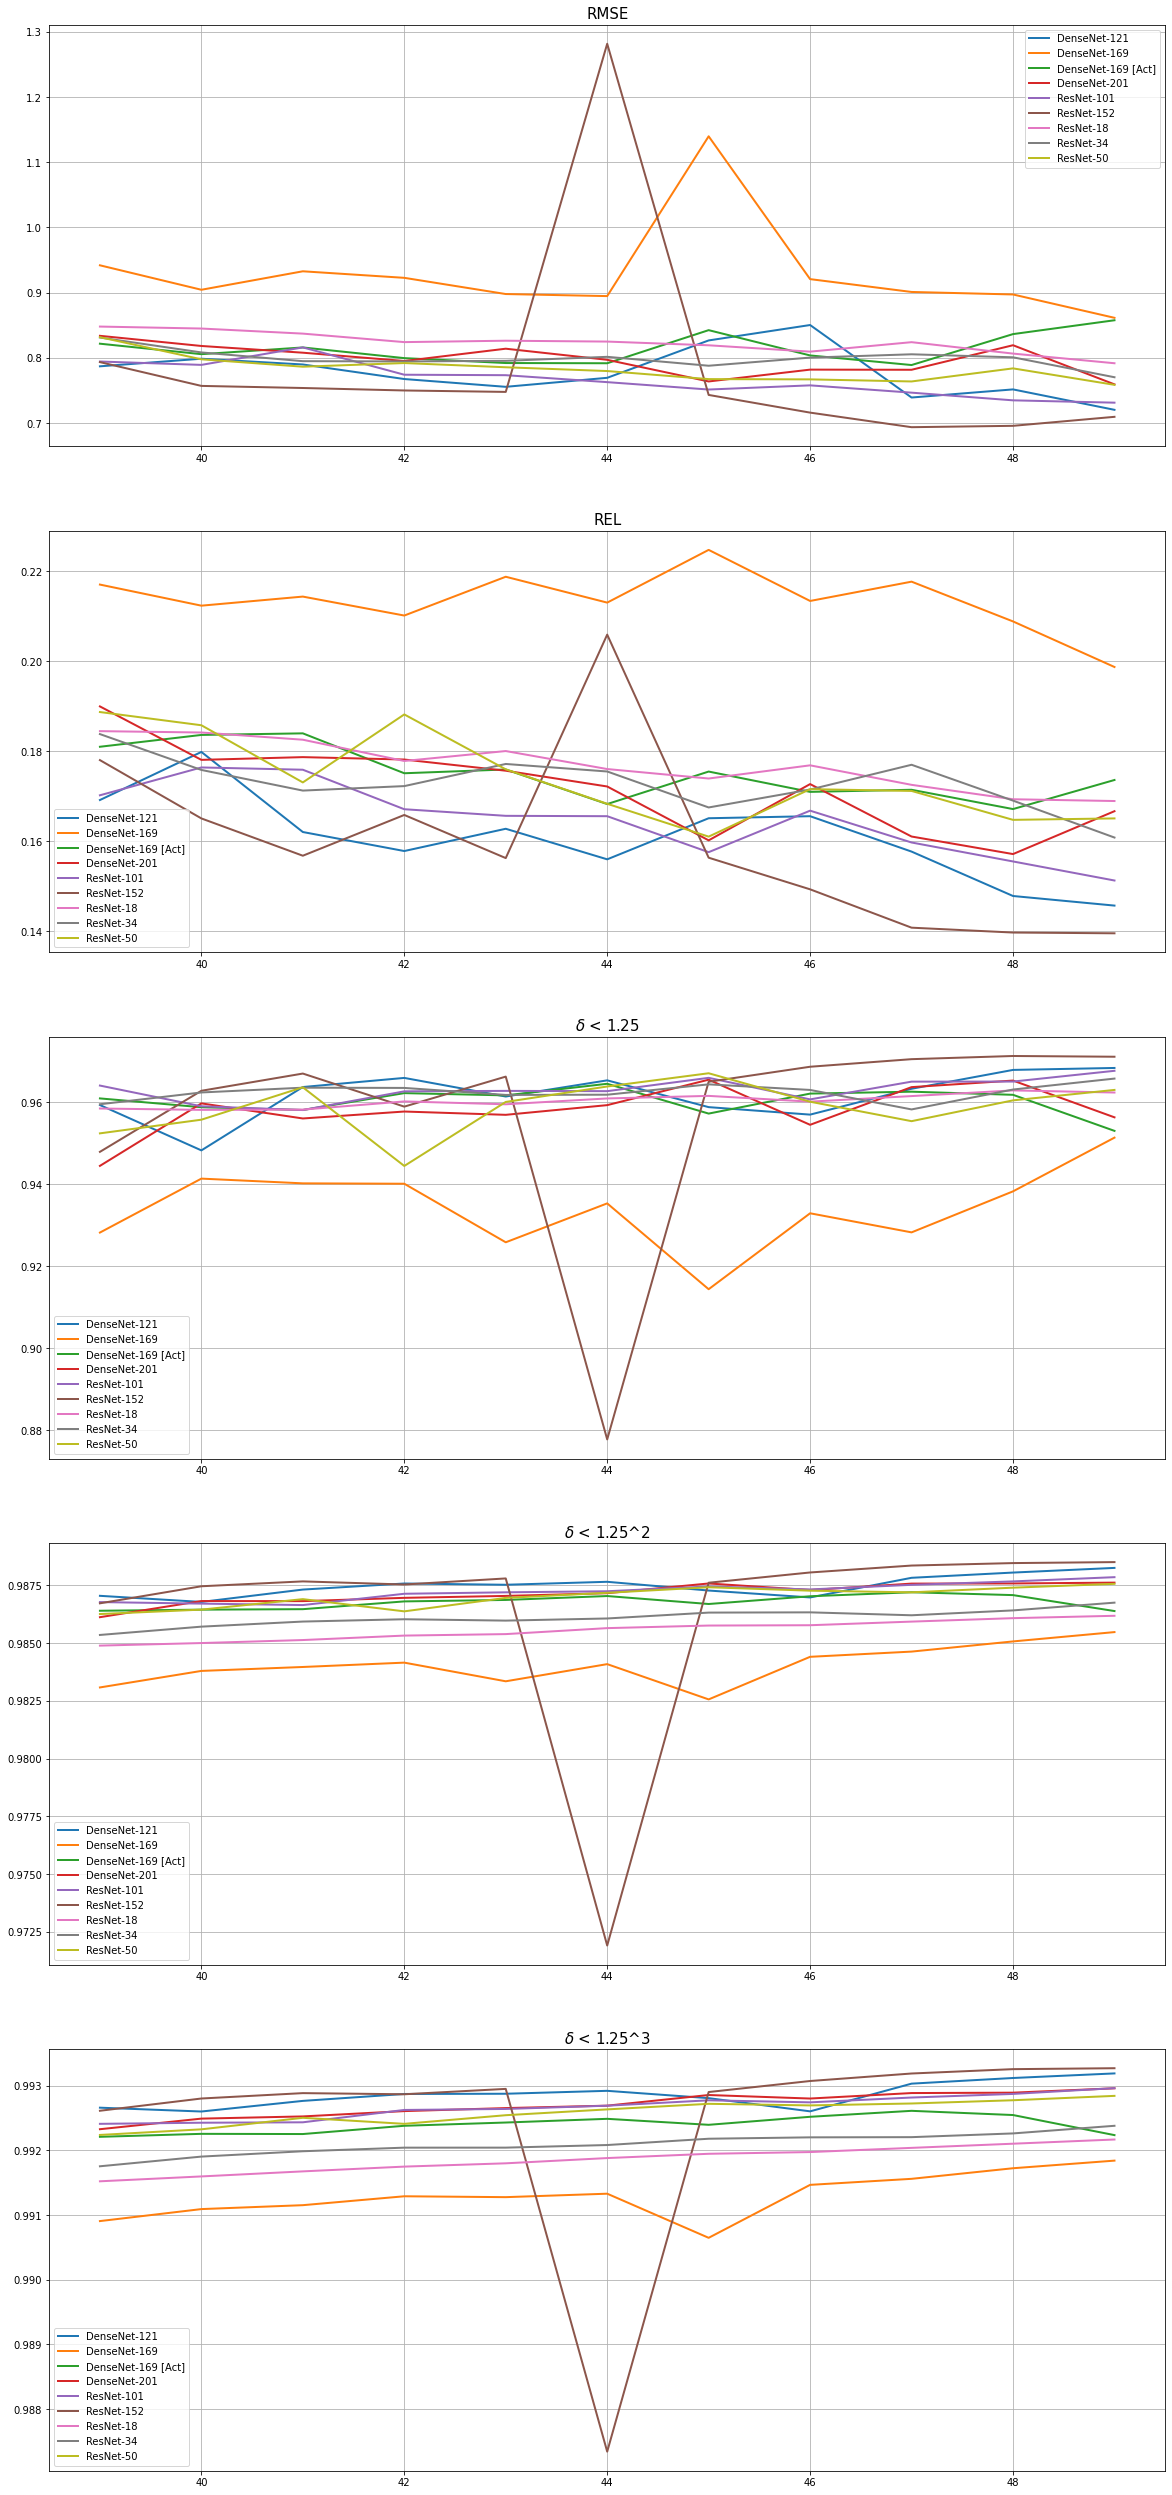

In [14]:
# Show RMSE
show_cols = ['rmse', 'rel', 'acc_1', 'acc_2', 'acc_3']
est_cols = ['RMSE', 'REL', '$\delta$ < 1.25', '$\delta$ < 1.25^2', '$\delta$ < 1.25^3']

figsize_show_per_row = (20, 45)
figsize_show_per_cols = (30, 6)

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=figsize_show_per_row)
for i in range(len(show_cols)):
    ax[i].set_title(est_cols[i], fontsize=15)
    ax[i].grid(True)
    for df, model in zip(df_readed, model_name): 
        ax[i].plot(df[show_cols[i]][39:], label=model, lw=2)

    ax[i].legend()